In [11]:
import csv
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

In [3]:
dataset = pd.read_csv('final_dataset.csv')
df = dataset.copy()
df.columns

Index(['Unnamed: 0', 'Flow.Duration', 'Total.Fwd.Packets',
       'Total.Backward.Packets', 'Total.Length.of.Fwd.Packets',
       'Total.Length.of.Bwd.Packets', 'Fwd.Packet.Length.Max',
       'Fwd.Packet.Length.Mean', 'Fwd.Packet.Length.Std', 'Flow.Bytes.s',
       'Flow.IAT.Mean', 'Flow.IAT.Std', 'Fwd.IAT.Mean', 'Fwd.IAT.Std',
       'Fwd.IAT.Max', 'Bwd.IAT.Mean', 'Bwd.IAT.Std', 'Fwd.PSH.Flags',
       'Fwd.Packets.s', 'Bwd.Packets.s', 'Max.Packet.Length',
       'Packet.Length.Mean', 'Packet.Length.Std', 'FIN.Flag.Count',
       'SYN.Flag.Count', 'ACK.Flag.Count', 'URG.Flag.Count', 'ECE.Flag.Count',
       'Down.Up.Ratio', 'Subflow.Fwd.Packets', 'Subflow.Fwd.Bytes',
       'Subflow.Bwd.Packets', 'Subflow.Bwd.Bytes', 'Init_Win_bytes_forward',
       'Init_Win_bytes_backward', 'min_seg_size_forward', 'Active.Mean',
       'Active.Std', 'Idle.Mean', 'Idle.Std', 'Protocol:Unknown',
       'Protocol.TCP', 'Protocol.UDP', 'ProtocolName.FreqEnc',
       'Source.IP.Value', 'Destination.IP.V

### 1. Remove dummy column

In [5]:
df.drop(columns=['Unnamed: 0'], inplace=True)

### 2. Resampling - create reference dataset and dataset for testing phase

In [10]:
REFERENCE_SIZE = 250_000
df_reference = df.sample(n=REFERENCE_SIZE)
df_reference.shape

(250000, 47)

In [12]:
reference_dataset_indeces = []

for index, _ in df_reference.iterrows():
    reference_dataset_indeces.append(index)

with open('[k-NN] reference indeces.csv', 'w', newline='') as f:
    write = csv.writer(f)
    write.writerow(['index'])
    write.writerow([idx] for idx in sorted(reference_dataset_indeces))

In [13]:
df_testing = df[~df.isin(df_reference)].dropna()

In [14]:
print(f"Entire dataset has {df.shape[0]} samples.")
print(f"Reference dataset has {df_reference.shape[0]} samples.")
print(f"Testing dataset has {df_testing.shape[0]} samples.")

Entire dataset has 3577296 samples.
Reference dataset has 250000 samples.
Testing dataset has 3327296 samples.


### 3. k-NN

In [15]:
K = 5
neighbors = NearestNeighbors(n_neighbors=K)
neighbors.fit(df_reference.values)
distances, _ = neighbors.kneighbors(df_reference.values)

In [16]:
distances_nei = distances.copy()

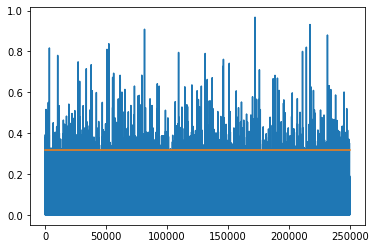

In [21]:
# Including self-sample distances - zeros
plt.plot(distances_nei.mean(axis=1))
plt.plot([0,250_000], [np.percentile(distances_nei, 99.5), np.percentile(distances_nei, 99.5)])

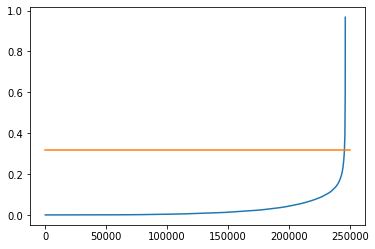

In [22]:
distances_mean_non_zeros = distances_nei.mean(axis=1)[distances_nei.mean(axis=1) != 0]
plt.plot(np.sort(distances_mean_non_zeros))
plt.plot([0,250_000], [np.percentile(distances_nei, 99.5), np.percentile(distances_nei, 99.5)])

Distribution of distances' value is that the vast majority is slightly close to zero. Ploting sorted data indicates that anomalous threshold can be taken as the 99.5 centile (empirical adjustment). Finally, each newly arrived sample in the network traffic with the distance higher than threshold, could be interpretted as anomalous sample.

### 4. Separation of anomalous samples from test dataset

In [23]:
anomalous_distance_threshold = np.percentile(distances_nei, 99.5)

In [24]:
anomalous_df = []

start = time.time()

for index, row in df_testing.iterrows():
    distance, _ = neighbors.kneighbors([np.array(row.tolist())])
    
    if distance.mean() > anomalous_distance_threshold:
        anomalous_df.append(index)

stop = time.time() - start
avg_time = stop/df_testing.shape[0]
print(f"Avg processing time of single sample {avg_time:.5f}")

Discovered 21310 samples to be suspected as anomalous. <br>
Avg processing time of single sample 0.00251

In [ ]:
with open('[k-NN] anonmalous indeces.csv', 'w', newline='') as f:
    write = csv.writer(f) 
    write.writerow(['index'])
    write.writerows([element] for element in anomalous_df)

In [ ]:
anomalous_full_df = df.iloc[anomalous_df,:]
anomalous_full_df.to_csv('anomalous_dataset.csv', index=False, header=True)